In [3]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# K.set_image_dim_ordering('tf')
keras.backend.set_image_data_format('channels_last')

Define weighted f1 and balanced accuarcy

In [6]:
def evaluate(predicted_outcome, expected_outcome):
    from sklearn import metrics
    f1_score = metrics.f1_score(expected_outcome, predicted_outcome, average='weighted')
    balanced_accuracy_score = metrics.balanced_accuracy_score(expected_outcome, predicted_outcome)
    return f1_score, balanced_accuracy_score

Read data and split validation set

In [7]:
def load_dataset_with_processing(input_train_test_fn, num_classes=10):
    data = np.load(input_train_test_fn)
    X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']
    
    # split validation set
    from sklearn.model_selection import train_test_split
    X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)
    
    X_train = np.array(X_train, dtype="float") / 255.0
    X_train = X_train.reshape(X_train.shape[0], 28, 28,1 )
    print(X_train.shape)
    
    X_vali = np.array(X_vali, dtype="float") / 255.0
    X_vali = X_vali.reshape(X_vali.shape[0], 28, 28,1 )
    print(X_vali.shape)
    
    X_test = np.array(X_test, dtype="float") / 255.0
    X_test = X_test.reshape(X_test.shape[0], 28, 28,1 )
    print(X_test.shape)
    
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_vali = keras.utils.to_categorical(y_vali, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return X_train, y_train, X_vali, y_vali, X_test, y_test

Build a data generator

In [8]:
def myGenerator(X_train, y_train, batch_size):    
    total_size = X_train.shape[0]
    
    while True:
        permutation = list(np.random.permutation(total_size))
        for i in range(total_size//batch_size):
            index = permutation[i * batch_size : (i + 1) * batch_size]
            X_batch = X_train[index]
            y_batch = y_train[index]
                    
            yield X_batch, y_batch

Build the lenet model with pretrained weights

In [9]:
def build_model(input_shape, num_classes):
    # initialize the model
    model = Sequential()
    model.add(Conv2D(20, (5, 5), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))
    
    for layer in model.layers:
        layer.trainable = False  # freeze the previous layers
    
    X = model.output
    # softmax classifier
    predictions = Dense(10, activation='softmax')(X)
    old_model = Model(inputs=model.input, outputs=predictions)
    
    # load weights
    old_model.load_weights('./pretrained_mnist/lenet.hdf5')

    X = model.output
    # softmax classifier
    predictions = Dense(num_classes, activation='softmax')(X)
    new_model = Model(inputs=model.input, outputs=predictions)

    new_model.summary()
    
    return new_model
    
input_shape = (28, 28, 1)
num_classes = 10
model = build_model(input_shape, num_classes)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0   

Define the training function

In [15]:
def train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs):
    import os
    if os.path.exists(checkpoint_dir) is False:
        os.makedirs(checkpoint_dir)

    model = build_model(input_shape, num_classes)
    
    checkpoint = ModelCheckpoint(checkpoint_dir + 'best.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

    
    #Compile Keras Model 
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    
    datagen = myGenerator(X_train, y_train, batch_size)
    
    history = model.fit_generator(datagen,
                        steps_per_epoch = len(X_train) // batch_size,
                        epochs=epochs,
                        callbacks=[es, checkpoint],
                        verbose=2,
                        validation_data=(X_vali, y_vali))
    
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()
    
    return model

Define the testing function

In [11]:
def test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights):
    model = build_model(input_shape, num_classes)

    # Compile Keras Model 
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    
    # load weights
    model.load_weights(pretrained_weights)
    
    score = model.evaluate(X_test, y_test, verbose=0)
    
    testPredict = model.predict(X_test)
    y_test_tmp = np.argmax(y_test, axis=1)
    y_pred_tmp = np.argmax(testPredict, axis=1)
    f1_score, balanced_accuracy_score = evaluate(y_pred_tmp, y_test_tmp)
    
    return score[1], f1_score, balanced_accuracy_score  # return accuracies

Now we train the LeNet model

(395688, 28, 28, 1)
(98922, 28, 28, 1)
(107158, 28, 28, 1)
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
activation_9 (Activation)    (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_10 (Activation)   (None, 14, 14, 50)        0         
_________________________________________________________________


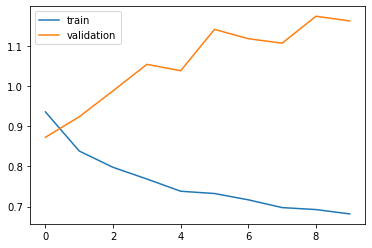

In [16]:
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(lr=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './LeNet_MNIST_MIX/'
input_train_test_fn = './data/MNIST_MIX_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

Then we test the saved model

In [17]:
pretrained_weights = './LeNet_MNIST_MIX/best.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
activation_12 (Activation)   (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_13 (Activation)   (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 50)          0   

Plot the confusion matrix for different languages

In [18]:
languages = ['Arabic', 'Bangla', 'Devanagari', 'English', 'Farsi', 'Kannada', 'Swedish', 'Telugu', 'Tibetan', 'Urdu']

In [20]:
model = build_model(input_shape, num_classes)

# Compile Keras Model 
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
    
# load weights
model.load_weights(pretrained_weights)
    
testPredict = model.predict(X_test)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10_input (InputLayer) [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 20)        520       
_________________________________________________________________
activation_15 (Activation)   (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_16 (Activation)   (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 50)          0  

In [220]:
y_test_tmp = np.floor(np.argmax(y_test, axis=1) / 10).astype(int)
y_pred_tmp = np.floor(np.argmax(testPredict, axis=1) / 10).astype(int)

In [221]:
label_mapping = {i:languages[i] for i in range(10)}
label_mapping

{0: 'Arabic',
 1: 'Bangla',
 2: 'Devanagari',
 3: 'English',
 4: 'Farsi',
 5: 'Kannada',
 6: 'Swedish',
 7: 'Telugu',
 8: 'Tibetan',
 9: 'Urdu'}

In [222]:
y_true = [label_mapping[i] for i in y_test_tmp]
y_pred = [label_mapping[i] for i in y_pred_tmp]

In [223]:
y_true[:10]

['Arabic',
 'Arabic',
 'Arabic',
 'Arabic',
 'Arabic',
 'Arabic',
 'Arabic',
 'Arabic',
 'Arabic',
 'Arabic']

In [224]:
y_pred[:10]

['Urdu',
 'Farsi',
 'Arabic',
 'Arabic',
 'Farsi',
 'Arabic',
 'Arabic',
 'Farsi',
 'Bangla',
 'Arabic']

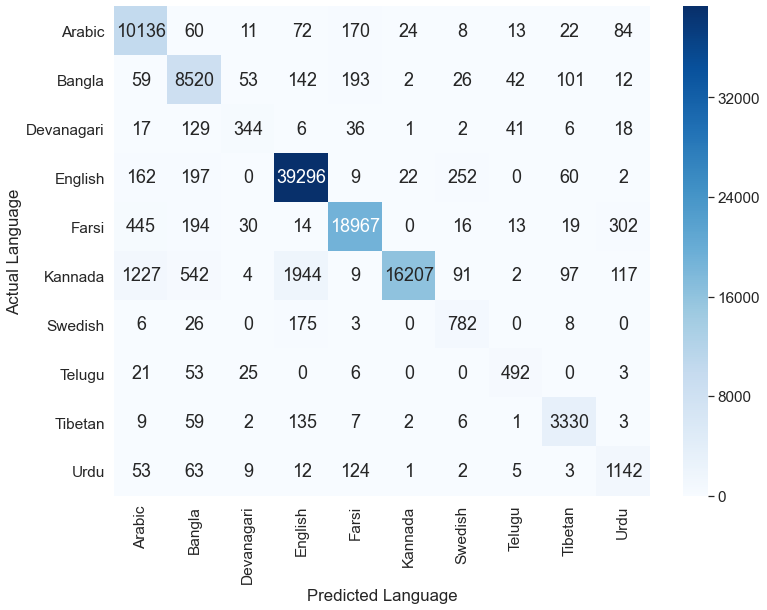

In [225]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual Language'
df_cm.columns.name = 'Predicted Language'
plt.figure(figsize = (12, 9))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 18})  # font size
plt.savefig('languages-confusion-matrix.pdf', dpi=400, bbox_inches='tight')

Plot the confusion matrix for different numbers

In [226]:
y_test_tmp = np.floor(np.argmax(y_test, axis=1) % 10).astype(int)
y_pred_tmp = np.floor(np.argmax(testPredict, axis=1) % 10).astype(int)

In [227]:
label_mapping = {i:str(i) for i in range(10)}
label_mapping

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

In [228]:
y_true = [label_mapping[i] for i in y_test_tmp]
y_pred = [label_mapping[i] for i in y_pred_tmp]

In [229]:
y_true[:10]

['6', '5', '4', '5', '5', '2', '8', '0', '1', '4']

In [230]:
y_pred[:10]

['6', '5', '4', '5', '5', '2', '8', '0', '5', '4']

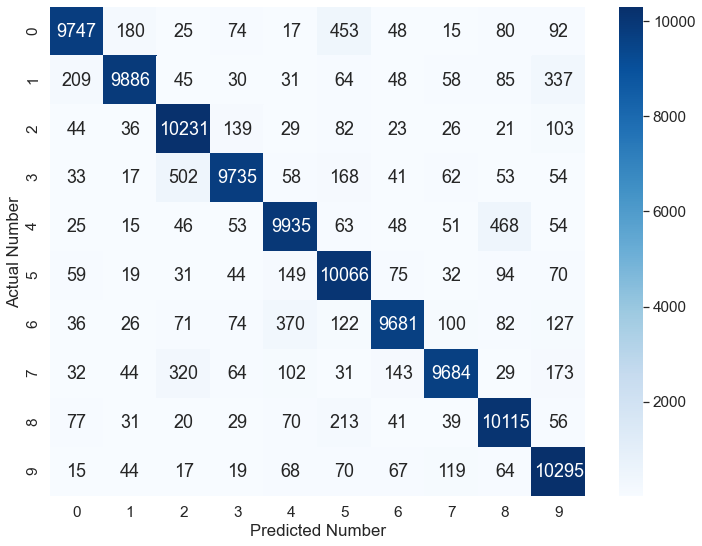

In [231]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual Number'
df_cm.columns.name = 'Predicted Number'
plt.figure(figsize = (12, 9))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 18})  # font size
plt.savefig('numbers-confusion-matrix.pdf', dpi=400, bbox_inches='tight')

Some further exploration

In [232]:
y_true = np.argmax(y_test, axis=1).astype(int)
y_pred = np.argmax(testPredict, axis=1).astype(int)

We can compare the confusion matrix between two numbers from one/two languages

In [234]:
def plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred):
    index1 = languages.index(language1) * 10 + number1
    index2 = languages.index(language2) * 10 + number2
    pairs = [(i, j) for i, j in zip(y_true, y_pred) if i in (index1, index2) and j in (index1, index2)]
    y_true_tmp, y_pred_tmp = zip(*pairs)
    
    label_mapping = {index1: language1 + ': ' + str(number1),
                     index2: language2 + ': ' + str(number2)}
    
    y_true = [label_mapping[i] for i in y_true_tmp]
    y_pred = [label_mapping[i] for i in y_pred_tmp]
    
    
    data = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(y_true), index=np.unique(y_true))
    df_cm.index.name = 'Actual Number'
    df_cm.columns.name = 'Predicted Number'
    plt.figure(figsize = (12, 9))
    sn.set(font_scale=1.4)  # for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 18})  # font size
    plt.savefig('%s-%s-%s-%s-confusion-matrix.pdf' % (language1, number1, language2, number2), dpi=400, bbox_inches='tight')

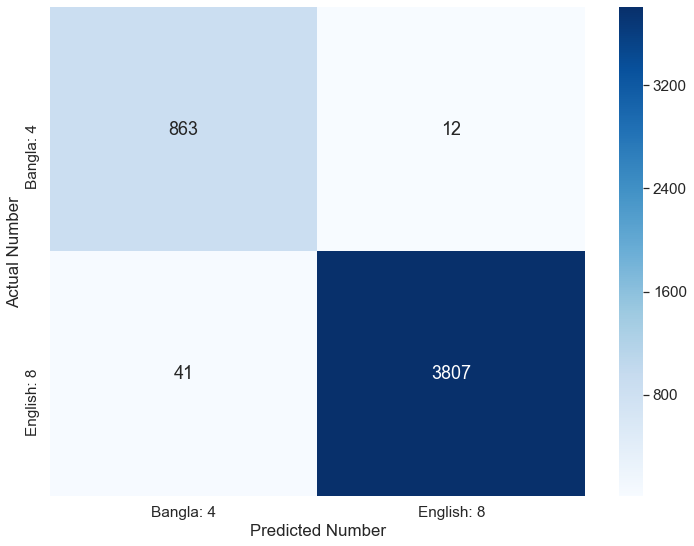

In [235]:
number1 = 4
language1 = 'Bangla'
number2 = 8
language2 = 'English'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

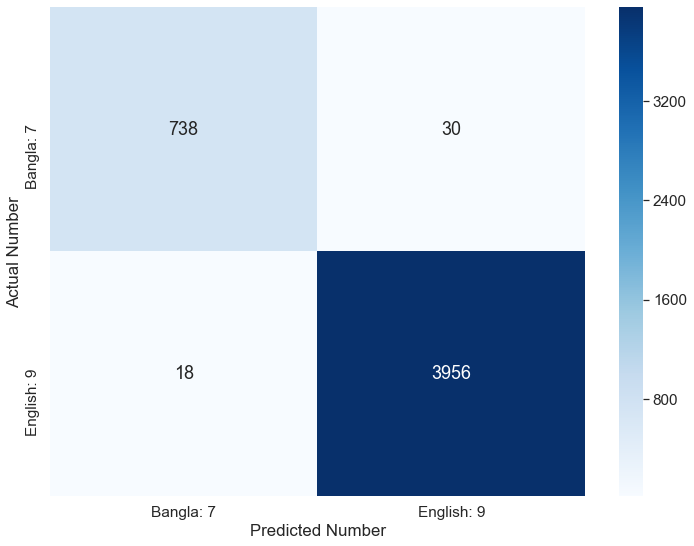

In [236]:
number1 = 7
language1 = 'Bangla'
number2 = 9
language2 = 'English'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

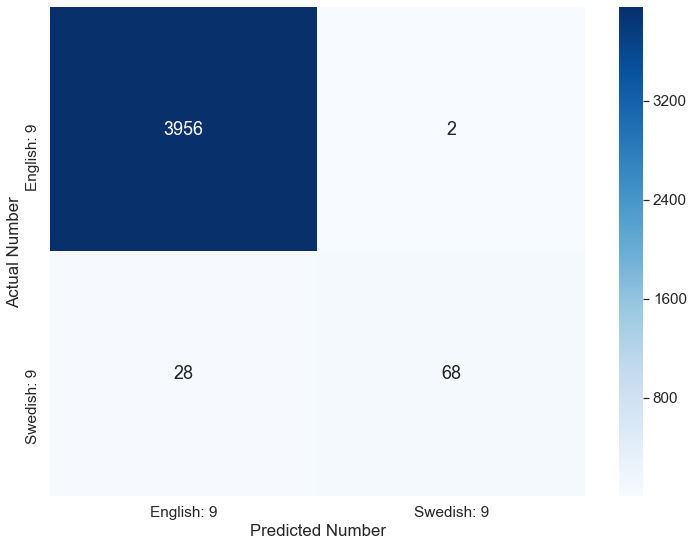

In [237]:
number1 = 9
language1 = 'Swedish'
number2 = 9
language2 = 'English'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

Then we want to find out which number pairs are the most difficult to distinguish:

In [238]:
from sklearn import metrics
def pair_comparison(number1, language1, number2, language2, languages, full_cm):
    index1 = languages.index(language1) * 10 + number1
    index2 = languages.index(language2) * 10 + number2
    
    tmp_cm = full_cm[[index1, index2], :][:, [index1, index2]]

    accuracy = sum(np.diag(tmp_cm)) / sum(tmp_cm.flatten())
    return number1, language1, number2, language2, accuracy

In [239]:
number1 = 9
language1 = 'Swedish'
number2 = 9
language2 = 'English'
full_cm = confusion_matrix(y_true, y_pred)
print(pair_comparison(number1, language1, number2, language2, languages, full_cm))

(9, 'Swedish', 9, 'English', 0.9925999013320178)


In [240]:
results = []
# calculate full confusion matrix
full_cm = confusion_matrix(y_true, y_pred)
for i1 in range(len(languages)):
    for i2 in range(i1, len(languages)):
        language1 = languages[i1]
        language2 = languages[i2]
        for number1 in range(10):
            for number2 in range(number1, 10):
                if language1 == language2 and number1 == number2:
                    continue
                results.append(pair_comparison(number1, language1, number2, language2, languages, full_cm))
results = sorted(results, key=lambda x:x[-1])

In [241]:
results[:10]

[(4, 'Devanagari', 4, 'Telugu', 0.7159090909090909),
 (1, 'Bangla', 9, 'Bangla', 0.8728763913298184),
 (4, 'Arabic', 6, 'Kannada', 0.8750495834986116),
 (8, 'Farsi', 8, 'Urdu', 0.8808743169398907),
 (0, 'Devanagari', 1, 'Telugu', 0.8850574712643678),
 (5, 'Devanagari', 6, 'Urdu', 0.916083916083916),
 (8, 'Arabic', 8, 'Farsi', 0.91816223977028),
 (0, 'Telugu', 1, 'Telugu', 0.918918918918919),
 (1, 'Devanagari', 9, 'Urdu', 0.9285714285714286),
 (0, 'Bangla', 0, 'Tibetan', 0.9324561403508772)]

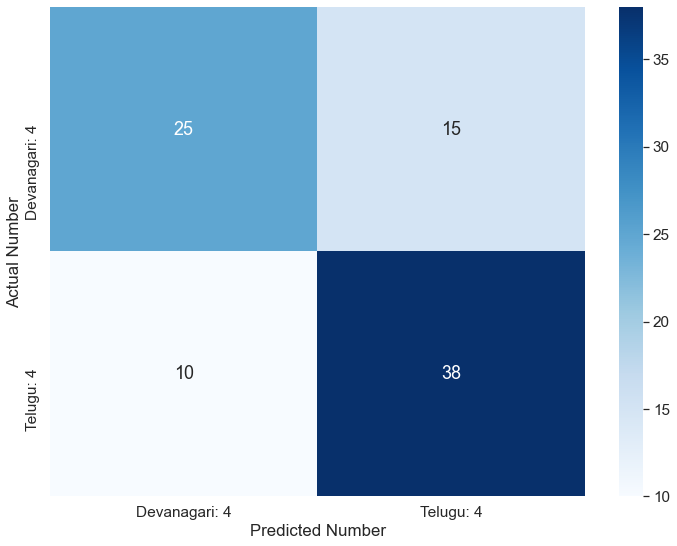

In [243]:
number1 = 4
language1 = 'Devanagari'
number2 = 4
language2 = 'Telugu'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

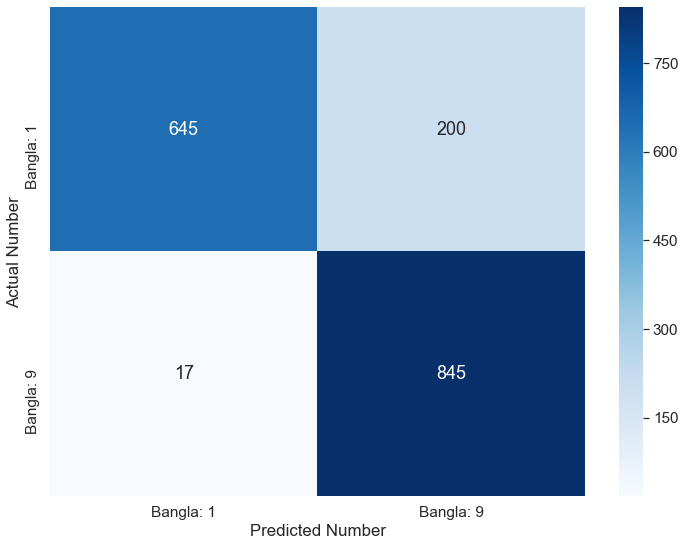

In [244]:
number1 = 1
language1 = 'Bangla'
number2 = 9
language2 = 'Bangla'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

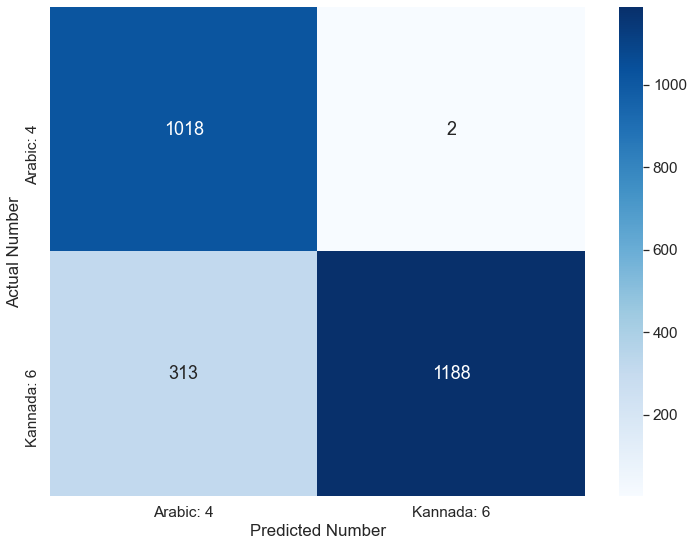

In [245]:
number1 = 4
language1 = 'Arabic'
number2 = 6
language2 = 'Kannada'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

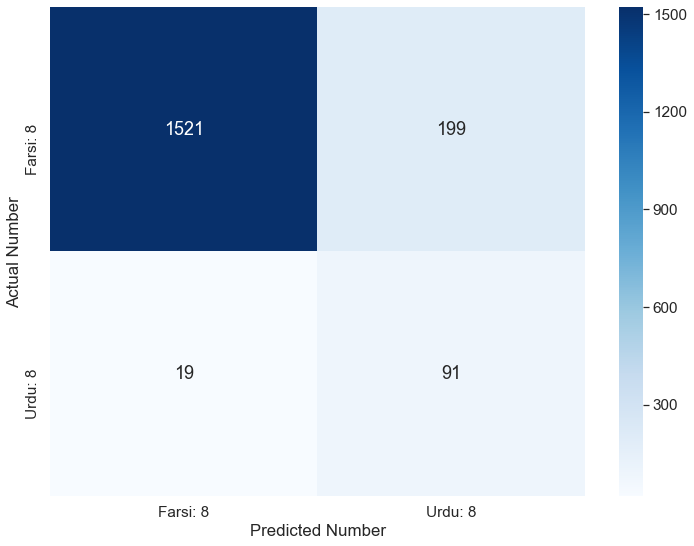

In [246]:
number1 = 8
language1 = 'Farsi'
number2 = 8
language2 = 'Urdu'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

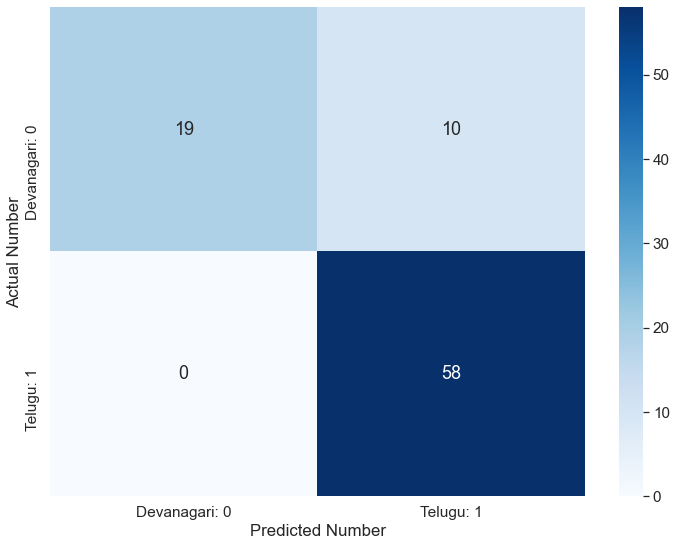

In [247]:
number1 = 0
language1 = 'Devanagari'
number2 = 1
language2 = 'Telugu'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

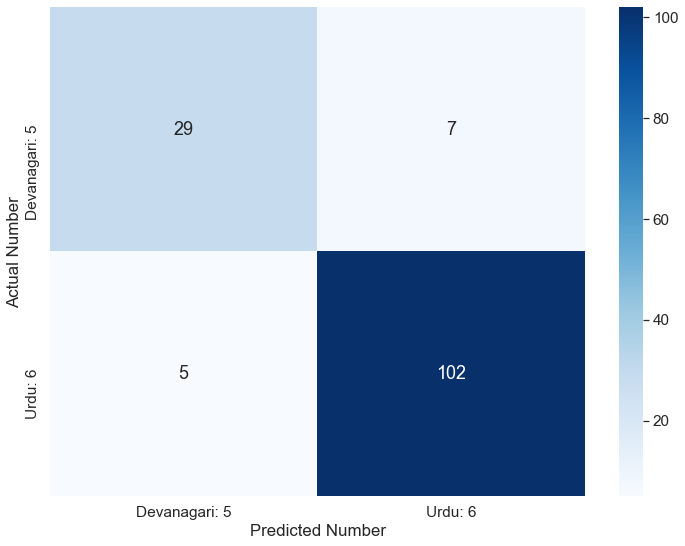

In [248]:
number1 = 5
language1 = 'Devanagari'
number2 = 6
language2 = 'Urdu'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

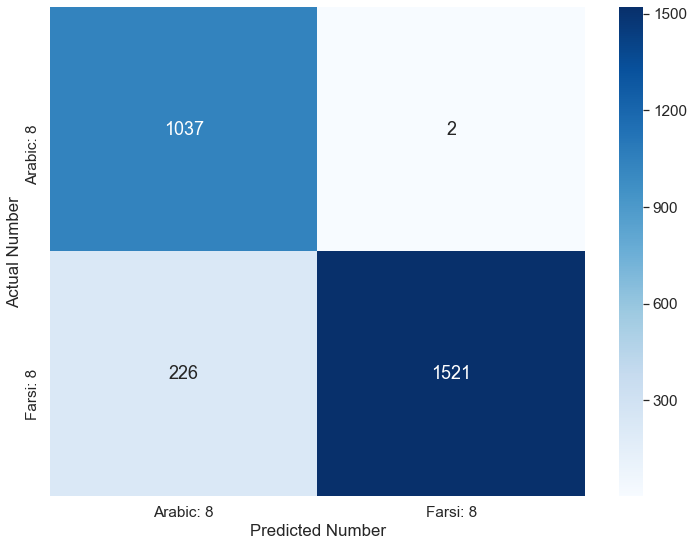

In [249]:
number1 = 8
language1 = 'Arabic'
number2 = 8
language2 = 'Farsi'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

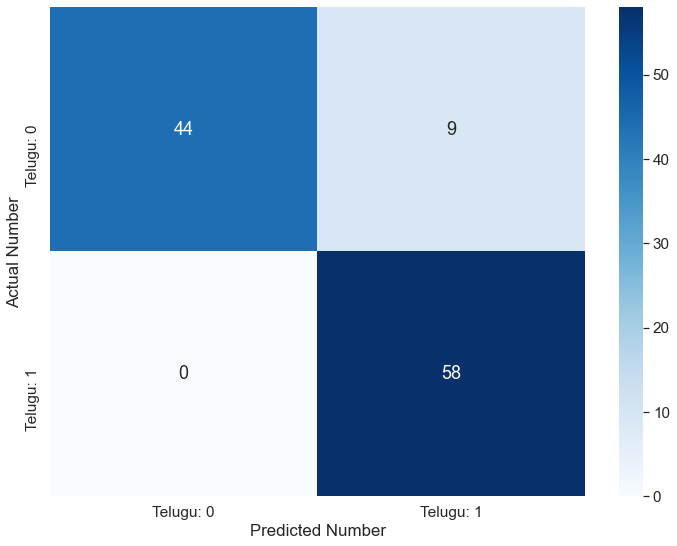

In [250]:
number1 = 0
language1 = 'Telugu'
number2 = 1
language2 = 'Telugu'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

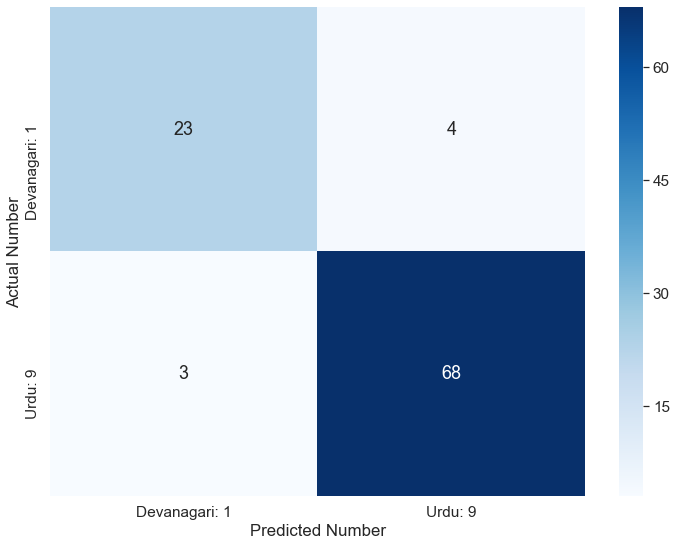

In [251]:
number1 = 1
language1 = 'Devanagari'
number2 = 9
language2 = 'Urdu'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

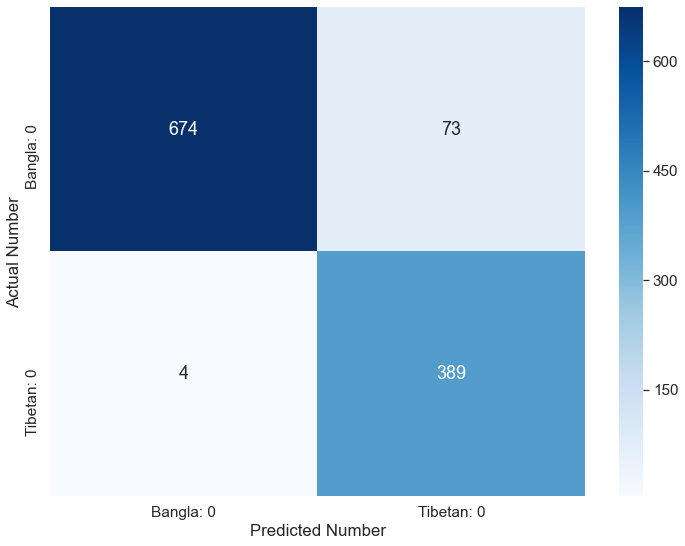

In [252]:
number1 = 0
language1 = 'Bangla'
number2 = 0
language2 = 'Tibetan'
plot_confusion_matrix(number1, language1, number2, language2, languages, y_true, y_pred)

Finally we want to make a visualization of these pairs:

In [216]:
# we get the images from the training set
def get_image_to_plot(input_train_test_fn, pairs):
    image_to_plot_line1 = []
    image_to_plot_line2 = []
    
    data = np.load(input_train_test_fn)
    X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']
    
    for pair in pairs:
        number1, language1, number2, language2, _ = pair
        index1 = languages.index(language1) * 10 + number1
        index2 = languages.index(language2) * 10 + number2
        
        # find two images to plot
        
        for (i, j) in zip(X_train, y_train):
            if j == index1:
                image_to_plot_line1.append(i)
                break
        for (i, j) in zip(X_train, y_train):
            if j == index2:
                image_to_plot_line2.append(i)
                break
    return [image_to_plot_line1, image_to_plot_line2]

In [217]:
pairs = results[:10]
input_train_test_fn = './data/MNIST_MIX_train_test.npz'
image_to_plot = get_image_to_plot(input_train_test_fn, pairs)
len(image_to_plot[0])

10

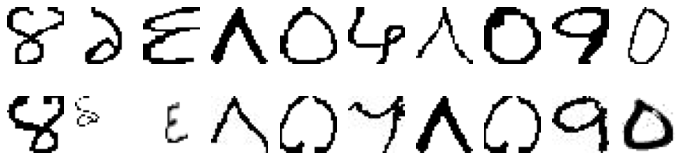

In [218]:
fig, axes = plt.subplots(2, 10, figsize=[12, 3])
# plt.subplots_adjust(wspace=0, hspace=0)
for i in range(2):
    for j in range(10):
        axes[i, j].imshow(255 - image_to_plot[i][j], cmap=plt.cm.gray)
        axes[i, j].axis('off')
plt.savefig('difficult_pairs.pdf', dpi=400, bbox_inches='tight')